In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%load_ext jupyternotify

import numpy as np

import torch
import torch.nn
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

from meld.recon import UnrolledNetwork
from meld.util import getAbs, getPhase
from meld.model import pytorch_proximal


import h5py
import mri
import model
import dataloader
import lib_complex as cp

# import sigpy

<IPython.core.display.Javascript object>

In [2]:
# Setup device
device_no = 2
torch.cuda.set_device(device_no)
device = torch.device("cuda:"+str(device_no) if torch.cuda.is_available() else "cpu")

np_dtype = np.float32
device

device(type='cuda', index=2)

In [3]:
datapath = './imgs_train_64.h5'
mapspath = './maps_train_reduced_64.h5'
maskpath = "./masks_train.h5"
dataset = dataloader.dataloader(datapath, 
                                noise_std = 5e-4, mask_path = maskpath, maps_path = mapspath, device=device, maskshift=False
                                , numcoils = 4)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)
imgs, maps, meas, mask = dataset[0]

imgs_test = imgs.unsqueeze(0).to(device)
maps_test = maps.unsqueeze(0).to(device)
meas_test = meas.unsqueeze(0).to(device)
mask_test = mask.unsqueeze(0).to(device)

/home/skware/MELD/experiment_mri/dataloader.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  mask_0 = torch.tensor(masks.astype(self.np_dtype))


In [4]:
datapath = './imgs_test_64.h5'
mapspath = './maps_test_reduced_64.h5'
maskpath = "./masks_test.h5"

testset = dataloader.dataloader(datapath, 
                                noise_std = 5e-4, mask_path = maskpath, maps_path = mapspath, device=device, maskshift=False
                                , numcoils = 4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=4)

In [5]:
meas_disp = mri.fft_adj(meas_test, ndim=3)

In [6]:
print(meas_test.shape, meas_disp.shape)

torch.Size([1, 4, 64, 256, 320, 2]) torch.Size([1, 4, 64, 256, 320, 2])


In [7]:
adjoint_test = torch.sum(meas_disp * cp.zconj(maps_test), 1)

<IPython.core.display.Javascript object>


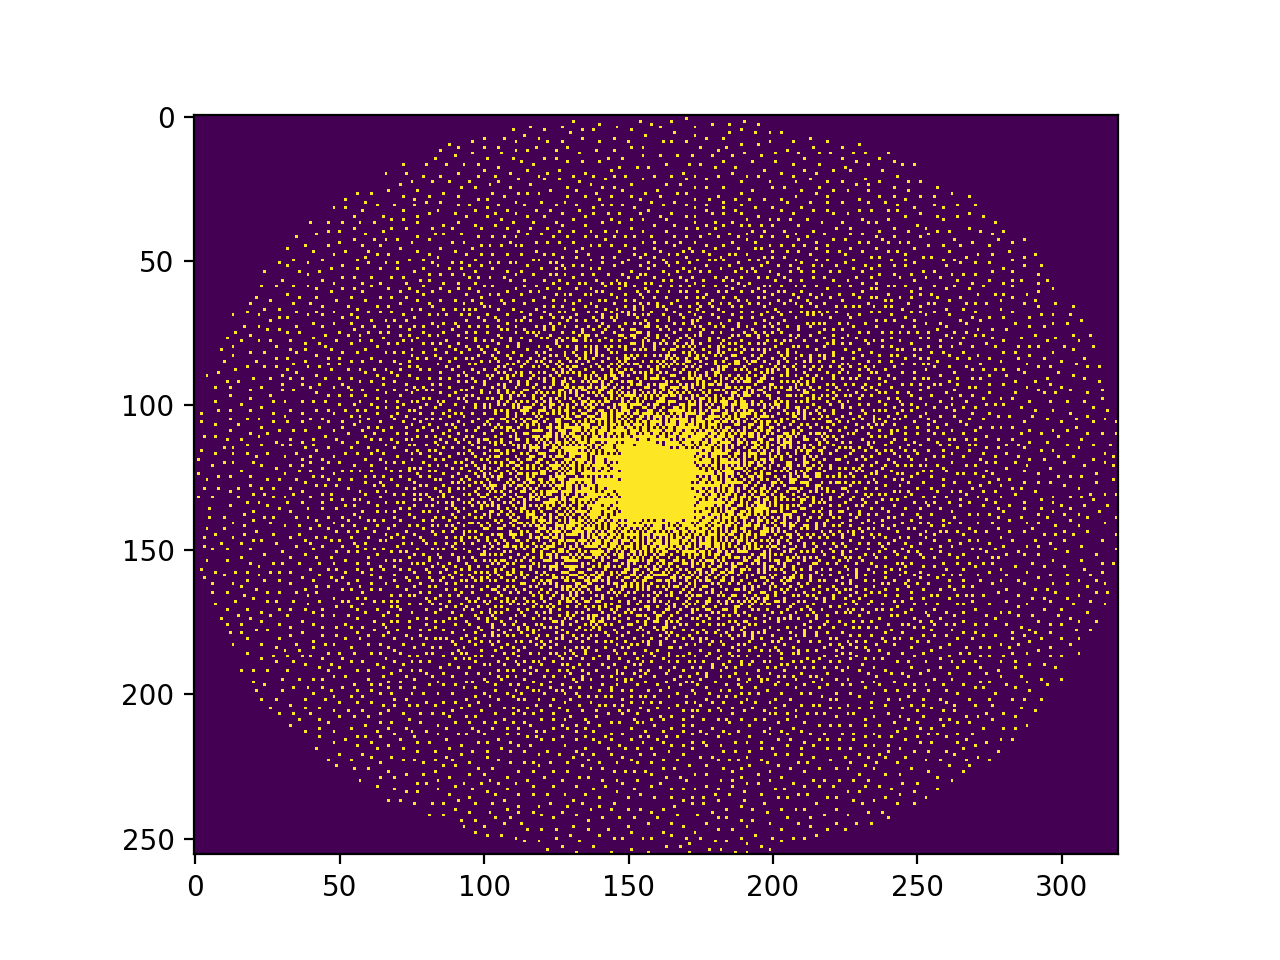

<IPython.core.display.Javascript object>


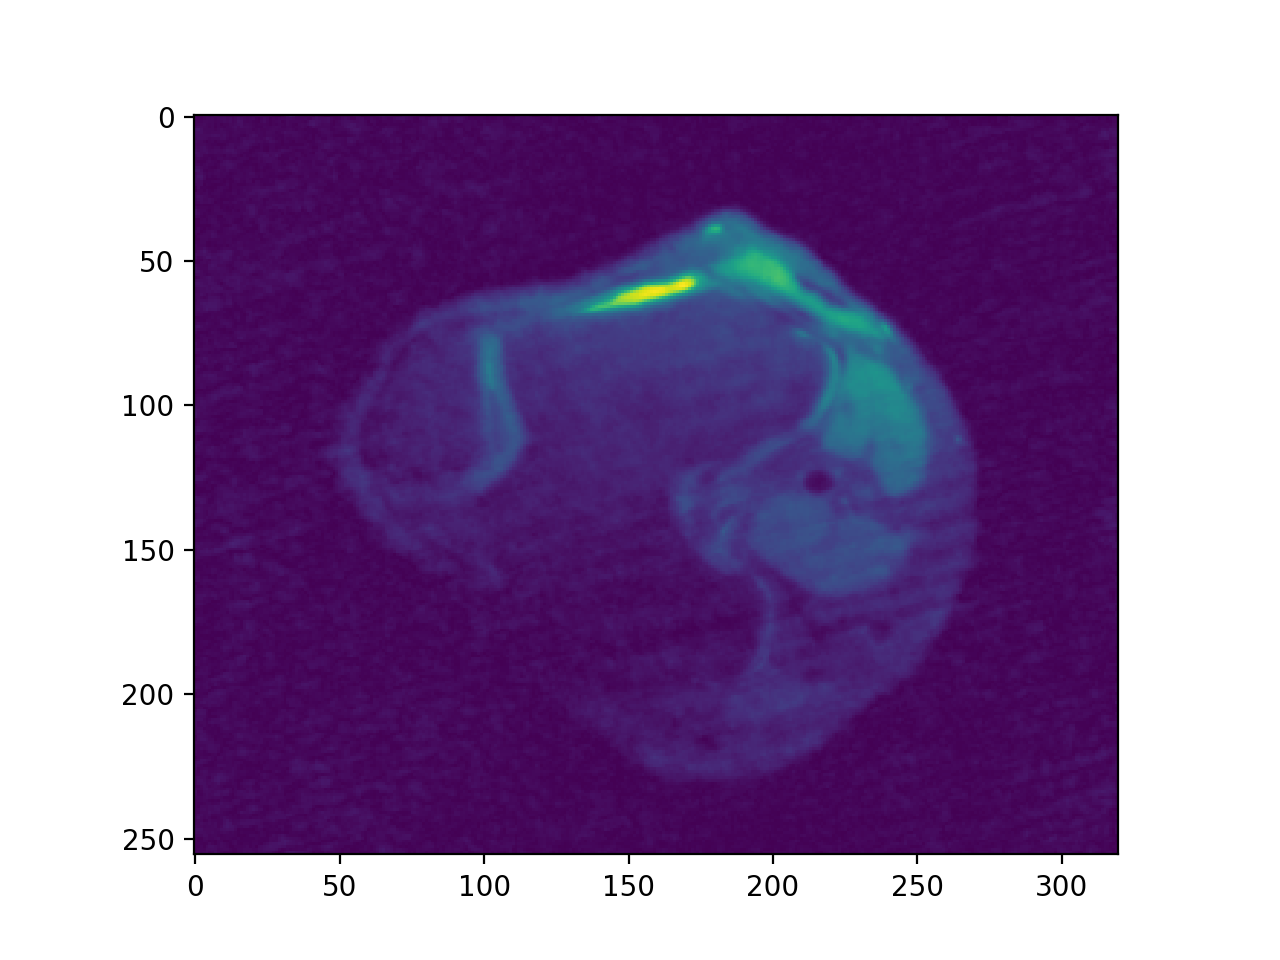

<IPython.core.display.Javascript object>


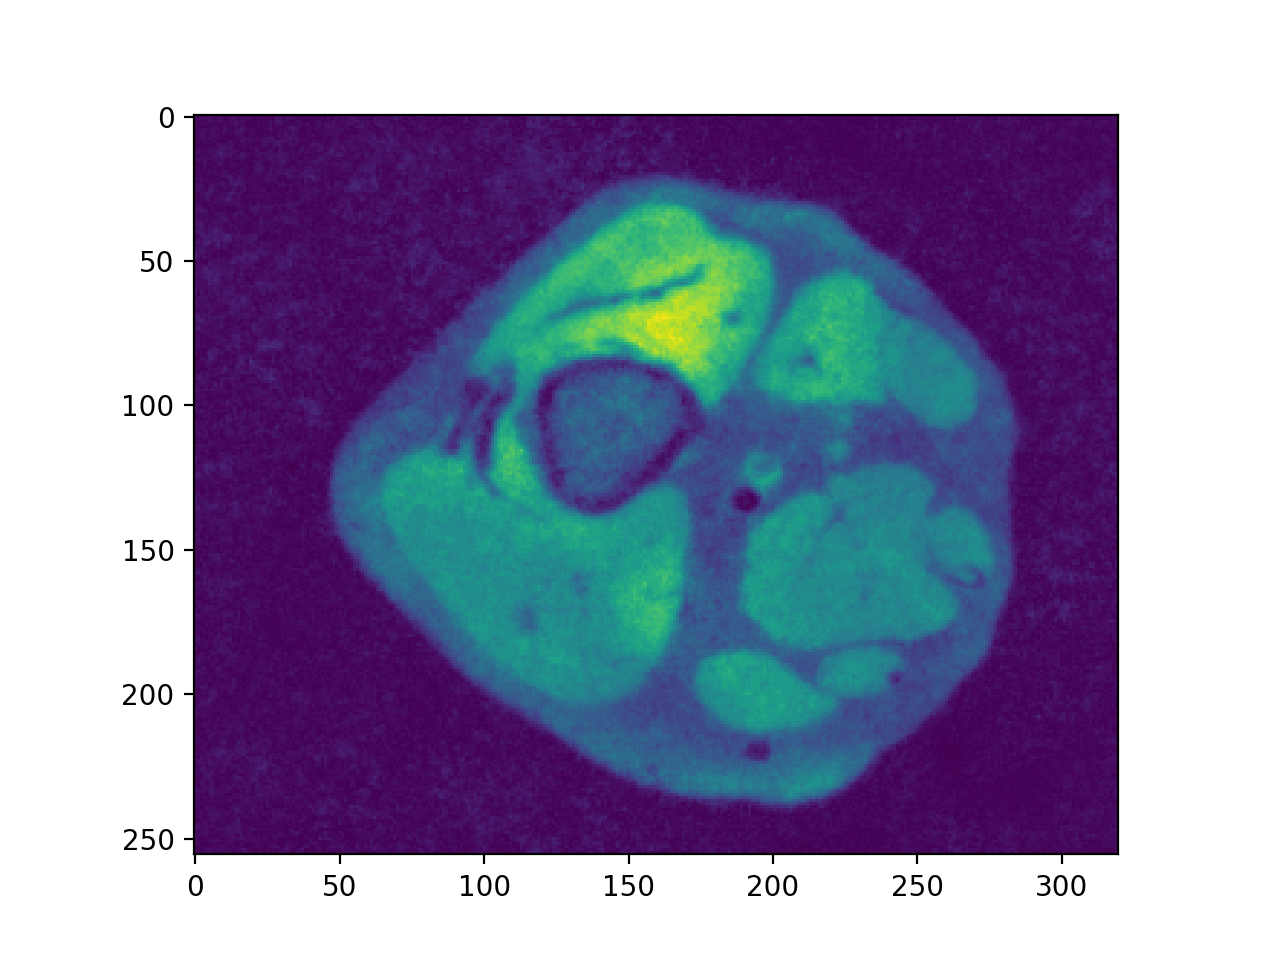

<IPython.core.display.Javascript object>


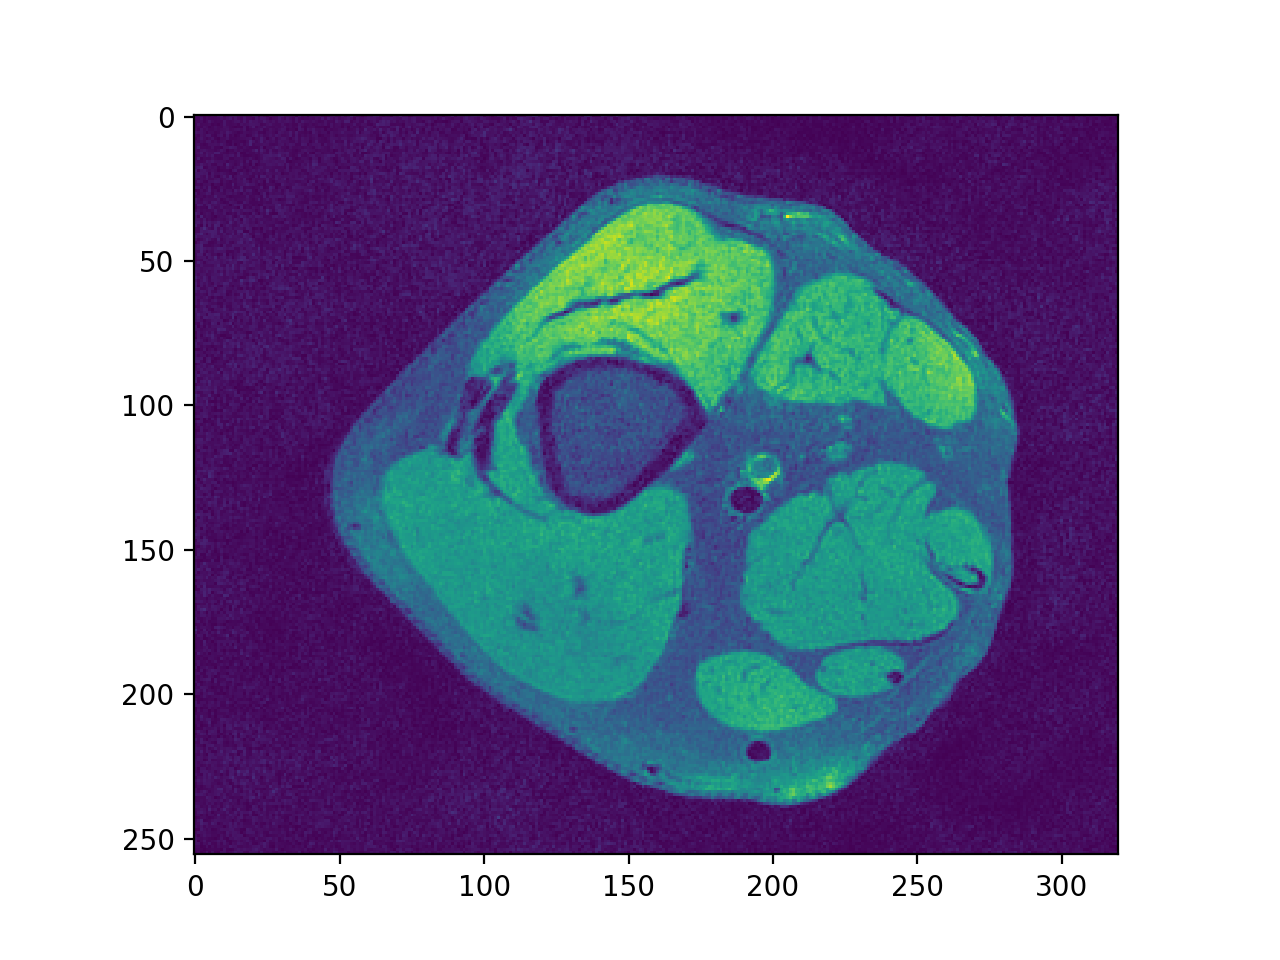

In [8]:
plt.figure()
plt.imshow(mask_test[0].cpu().numpy())
plt.figure()
plt.imshow(getAbs(meas_disp[0,0,30,...]).cpu().numpy())
plt.figure()
plt.imshow(getAbs(adjoint_test[0,1,...]).cpu().numpy())
plt.figure()
plt.imshow(getAbs(imgs_test[0,1,...]).cpu().numpy())
plt.show()

In [9]:
mri_model = mri.MultiChannelMRI(device = device, ndim=3)
adjoint1 = mri_model.batch(imgs_test, maps_test, meas_test, mask_test, device)
zeros_test = torch.zeros_like(adjoint1).to(device)
with torch.no_grad():
    recon = mri_model(zeros_test.to(device), device = device, max_iter=100, eps=1e-8)